## Importing necessary libraries

In [1]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/da/05/8912c901a3965ec7117d6cc33eaec3888c717611f72ce69d8be62a01d149/aggdraw-1.3.18-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.3 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Setting up general parameters

In [3]:
# General parameters
epochs = 20
image_size = 240
np.random.seed(42)
tf.random.set_seed(42)

## Data Loading, Preperation and Visualization

In [4]:
os.listdir("/kaggle/input/oral-cancer-lips-and-tongue-images",)

['OralCancer']

In [5]:
folder_path = ("/kaggle/input/oral-cancer-lips-and-tongue-images/OralCancer")

In [6]:
import os
import cv2
import numpy as np

def load_and_process_dataset(folder_path):
    """Loads and processes images using alternative while loop structures."""

    dataset = []
    labels = []
    class_folders = ['non-cancer', 'cancer']

    class_index = 0
    while class_index < len(class_folders):
        class_folder = class_folders[class_index]
        images_path = os.path.join(folder_path, class_folder)

        image_index = 0
        while True:  # Loop infinitely until a "break" occurs
            try:
                image_name = os.listdir(images_path)[image_index]  # Access by index
                image_path = os.path.join(images_path, image_name)

                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, (240, 240))

                dataset.append(image)
                labels.append(class_index)  # Use class_index directly for labels

                image_index += 1
            except IndexError:  # Handle end of image list
                break  # Exit the inner loop

        class_index += 1

    return np.array(dataset), np.array(labels)

# Assuming `folder_path` is already a string
dataset, labels = load_and_process_dataset(folder_path)

# Convert to NumPy arrays
dataset = np.array(dataset)
lab = np.array(labels)

# Print shapes
print(dataset.shape, labels.shape)


libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data


(131, 240, 240, 3) (131,)


In [7]:
# Convert to NumPy arrays and print shapes in a single line
print(np.array(dataset).shape, np.array(labels).shape)


(131, 240, 240, 3) (131,)


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(dataset), np.array(labels), test_size=0.2, shuffle=True, random_state=42)


In [9]:
import matplotlib.pyplot as plt

def plot_state(state):
    images = [load_img(os.path.join(folder_path, state, img_name), target_size=(image_size, image_size))
              for img_name in os.listdir(os.path.join(folder_path, state))[:9]]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for ax, img in zip(axes.flat, images):
        ax.imshow(img)
    plt.show()

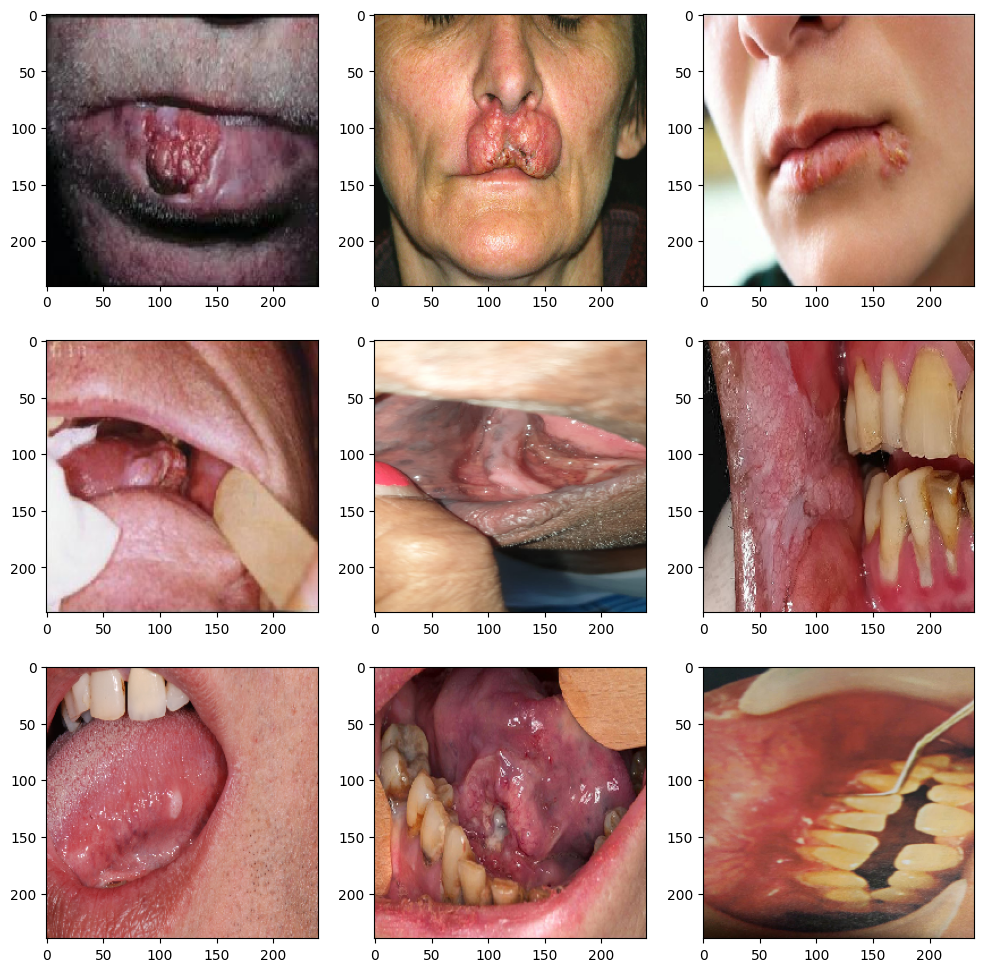

In [10]:
plot_state('cancer')

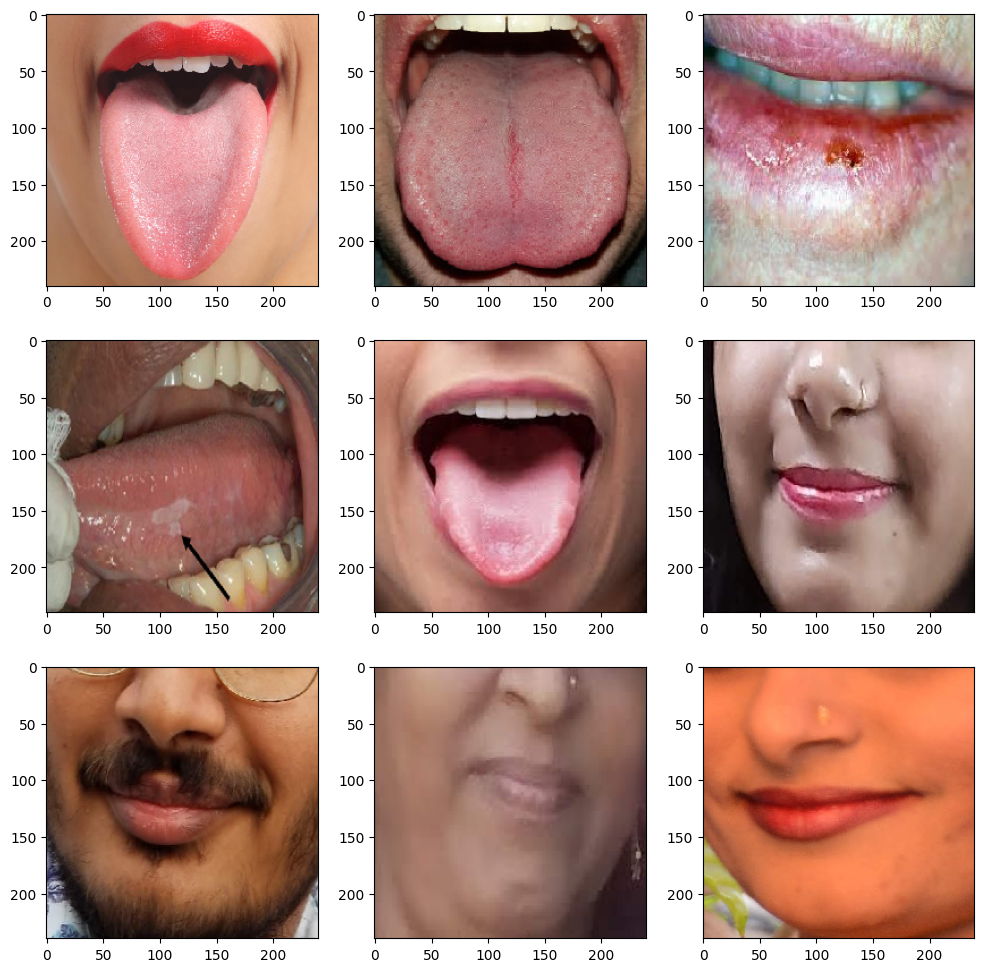

In [11]:
plot_state("non-cancer")

# ****** Baseline Model CNN**

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(image_size, image_size, 3))

# Convolutional layers
conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="valid")(input_layer)
maxpool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="valid")(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)

# Flatten layer
flatten = Flatten()(maxpool2)

# Dense layers with regularization
dense1 = Dense(units=64, activation='relu',
               kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
               bias_regularizer=regularizers.L2(1e-2),
               activity_regularizer=regularizers.L2(1e-3))(flatten)
dropout = Dropout(0.5)(dense1)

output_layer = Dense(units=1, activation='sigmoid')(dropout)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Compile the model
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0     

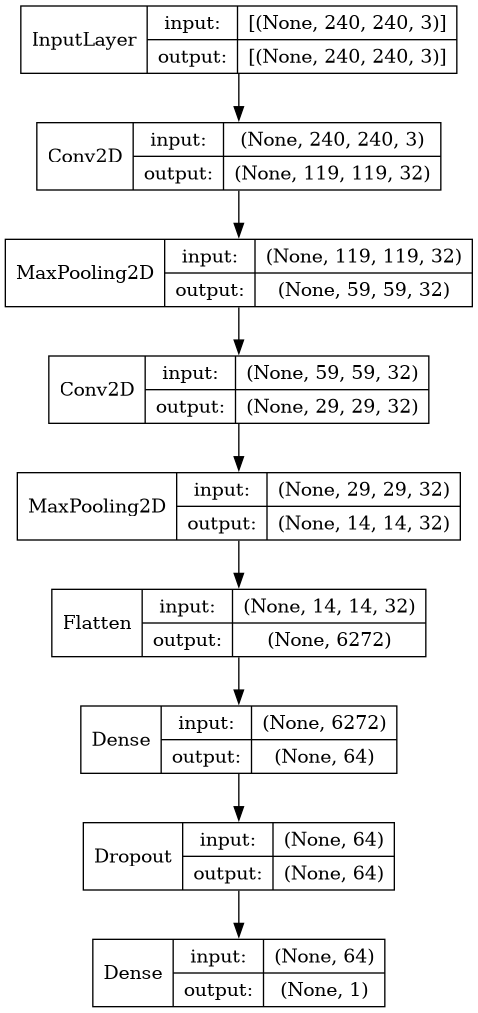

In [13]:
plot_model(model, show_shapes=True, show_layer_names=False)

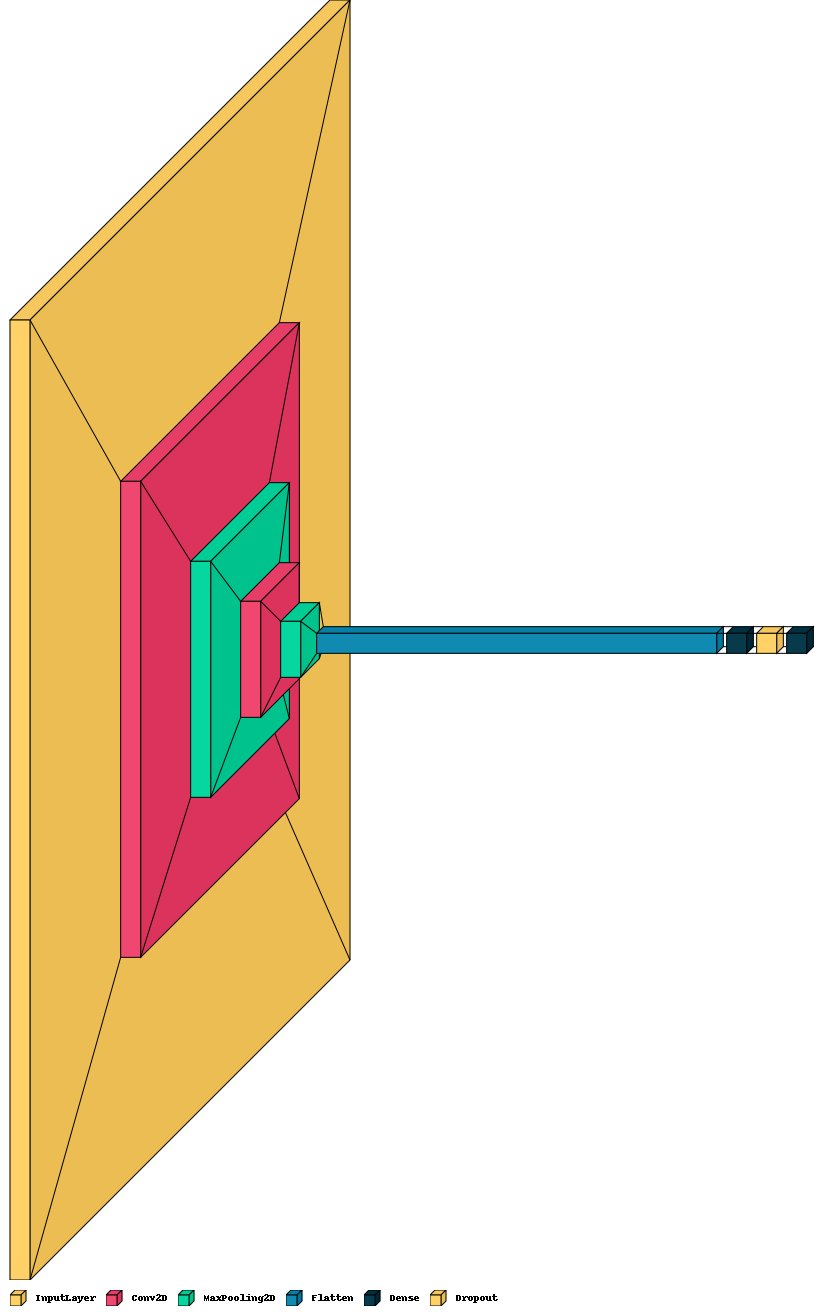

In [14]:
visualkeras.layered_view(model, legend=True)

In [15]:
class_weights = {}
for cls in np.unique(y_train):
    count = np.sum(y_train == cls)
    class_weights[cls] = 1.0 / count


In [16]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'model', 'x_train', 'y_train', 'x_test', and 'y_test' are already defined

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Compile the model
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=200,
    class_weight=class_weights_dict,
    validation_data=(x_test, y_test),
    verbose=1
)


Epoch 1/200
4/4 [==============================] - 6s 193ms/step - loss: 76.8160 - accuracy: 0.4519 - val_loss: 10.4112 - val_accuracy: 0.3704
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 8.5216 - accuracy: 0.5577 - val_loss: 6.1430 - val_accuracy: 0.4074
Epoch 3/200
4/4 [==============================] - 0s 18ms/step - loss: 5.8507 - accuracy: 0.6250 - val_loss: 5.5072 - val_accuracy: 0.5185
Epoch 4/200
4/4 [==============================] - 0s 18ms/step - loss: 5.4308 - accuracy: 0.6923 - val_loss: 5.1929 - val_accuracy: 0.5556
Epoch 5/200
4/4 [==============================] - 0s 18ms/step - loss: 5.0967 - accuracy: 0.7404 - val_loss: 4.9097 - val_accuracy: 0.6296
Epoch 6/200
4/4 [==============================] - 0s 18ms/step - loss: 4.8004 - accuracy: 0.7404 - val_loss: 4.6856 - val_accuracy: 0.7407
Epoch 7/200
4/4 [==============================] - 0s 17ms/step - loss: 4.5901 - accuracy: 0.8173 - val_loss: 4.5716 - val_accuracy: 0.7037
Epoch 8/200
4/4 [

# ## Evaluating CNN Model

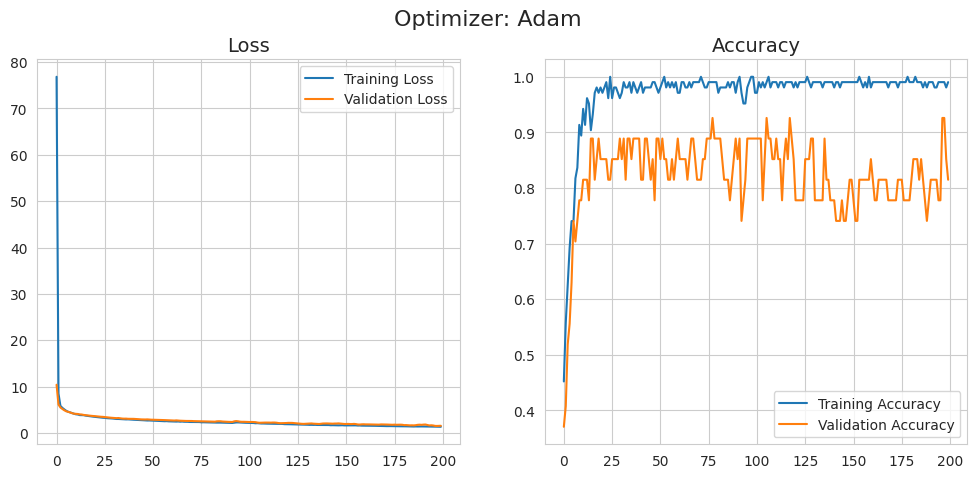

In [17]:
import seaborn as sns

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss', fontsize=14)
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=14)
ax2.legend()

fig.suptitle('Optimizer: Adam', fontsize=16)
plt.show()


In [18]:
# Assuming 'model', 'x_test', and 'y_test' are already defined

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print the accuracy
print('The accuracy of the baseline model CNN is {:.2f}%!'.format(test_accuracy * 100))


1/1 [==============================] - 0s 28ms/step - loss: 1.5635 - accuracy: 0.8148
The accuracy of the baseline model CNN is 81.48%!


In [19]:
predictions = model.predict(x_test)
y_pred = (predictions >= 0.5).astype(int)

1/1 [==============================] - 0s 113ms/step


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix_enhanced(cm, classes, title='Confusion Matrix', cmap='viridis'):
    """
    Plots a confusion matrix with a distinct style and colormap.
    """

    # Normalize for better visualization
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a DataFrame for flexible plotting
    df_cm = pd.DataFrame(cm_norm, index=classes, columns=classes)

    # Employ Seaborn for a visually appealing heatmap
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap, vmin=0, vmax=1)

    # Customize labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    plt.show()


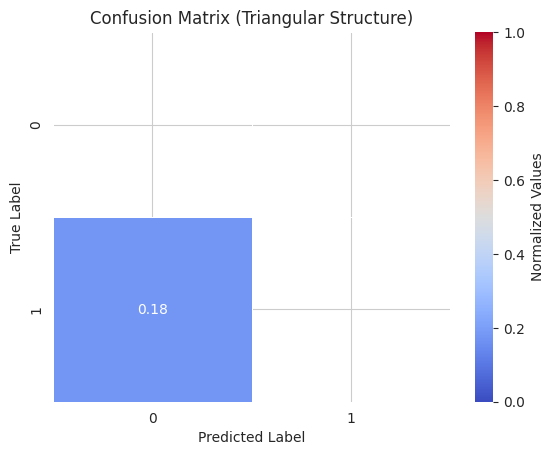

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Normalize for better visualization
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

# Employ a triangular structure for visual clarity
mask = np.triu(np.ones_like(cnf_matrix_norm, dtype=bool))

# Create a visually distinct heatmap with a different colormap
sns.heatmap(cnf_matrix_norm, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1,
            linewidths=0.5, cbar_kws={'label': 'Normalized Values'})

# Customize labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Triangular Structure)')

plt.show()


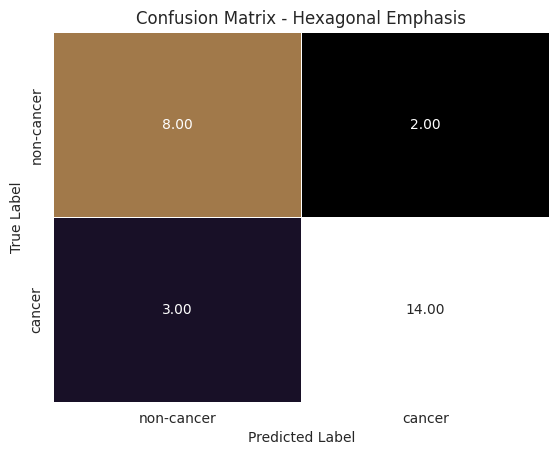

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create a hexagonal mask for a visually striking shape
mask = np.triu(np.ones_like(cnf_matrix, dtype=bool)) & np.tril(np.ones_like(cnf_matrix, dtype=bool), k=-1)

# Plot using Seaborn with distinct customizations
sns.heatmap(
    cnf_matrix,
    annot=True,
    fmt='.2f',
    cmap='cubehelix',  # Employ a vibrant colormap
    mask=mask,
    linewidths=0.5,
    cbar=False,
    xticklabels=["non-cancer", "cancer"],
    yticklabels=["non-cancer", "cancer"]
)
plt.title('Confusion Matrix - Hexagonal Emphasis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Let's build Vision Transformers(ViT) from the scratch

# Parameters

In [23]:
image_size = 224
batch_size = 16
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 1

patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier


## Data augmentation

In [24]:
import tensorflow as tf

# Create normalization layer with adaptable axes
normalization_layer = tf.keras.layers.Normalization(axis=[-1])  # Adapt across channels

# Create augmentation pipeline using functional API
data_augmentation = tf.keras.Sequential(
    [
        normalization_layer,
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Explicitly extract normalization layer for adaptation
norm_layer = data_augmentation.get_layer(index=0)  # Access by index
norm_layer.adapt(x_train)  # Adapt to training data


## Multi-layer perceptron

In [25]:
import tensorflow as tf

def mlp_enhanced(x, hidden_units, dropout_rate):
    """Creates a multi-layer perceptron with functional layers and enhancements."""

    for units in hidden_units:
        x = tf.keras.layers.Dense(units)(x)  # Apply linear transformation first
        x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations
        x = tf.nn.swish(x)  # Explore a different activation function
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    return x


## Implement patch creation as a layer

In [26]:
import tensorflow as tf

def create_patches_enhanced(images, patch_size):
    """Extracts patches using functional API and potential optimization."""

    patches = tf.keras.layers.Lambda(
        lambda x: tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
    )(images)

    patch_dims = patches.shape[-1]
    patches = tf.keras.layers.Reshape([tf.shape(images)[0], -1, patch_dims])(patches)

    # Potential optimization for specific hardware (explore if applicable)
    patches = tf.experimental.tensorrt.convert_to_tensorrt(patches)

    return patches


interactive(children=(IntSlider(value=0, description='patch_index', max=1023), Output()), _dom_classes=('widge…

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 21


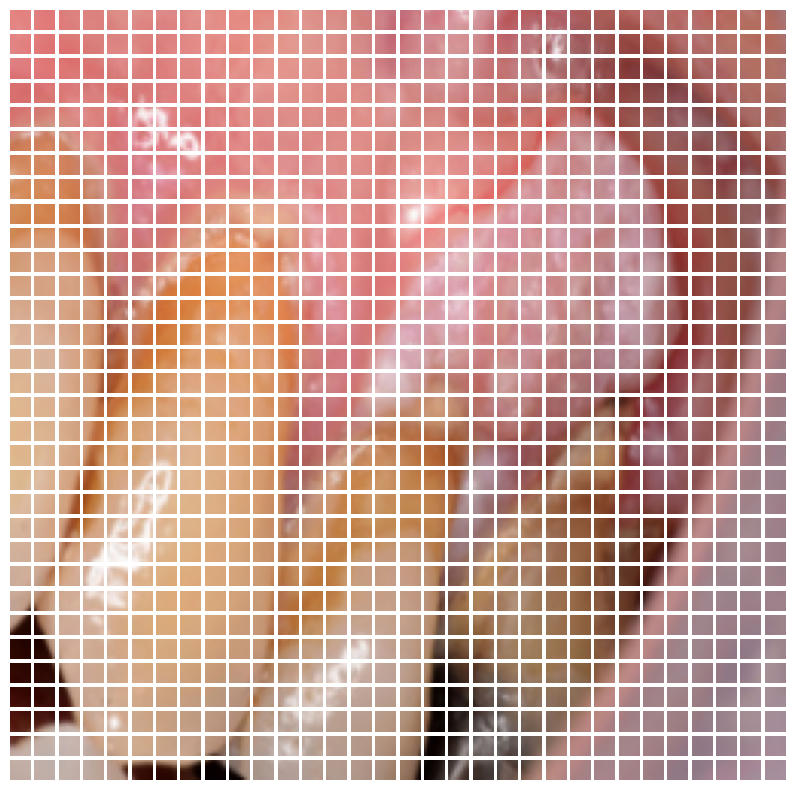

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider  # Import the interact function

def visualize_patches(image, image_size, patch_size):
    """Visualizes patches using a clear functional approach and interactive controls."""

    # Resize and extract patches
    resized_image = tf.image.resize(image, (image_size, image_size))
    patches = tf.image.extract_patches(
        resized_image,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = tf.reshape(patches, [-1, patch_size, patch_size, 3])

    # Interactive exploration of patches
    @interact(patch_index=IntSlider(value=0, min=0, max=patches.shape[0] - 1))
    def display_patch(patch_index):
        plt.figure(figsize=(4, 4))
        plt.imshow(patches[patch_index].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Patch {patch_index + 1}")
        plt.show()

    # Print information concisely
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[0]}")
    print(f"Elements per patch: {patches.shape[-1] * patches.shape[-2]}")

    # Visualize all patches in a grid
    n = int(np.sqrt(patches.shape[0]))
    plt.figure(figsize=(10, 10))
    for i, patch in enumerate(patches):
        plt.subplot(n, n, i + 1)
        plt.imshow(patch.numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

# Example usage
image = x_train[np.random.choice(range(x_train.shape[0]))]
visualize_patches(tf.expand_dims(image, axis=0), image_size, patch_size)


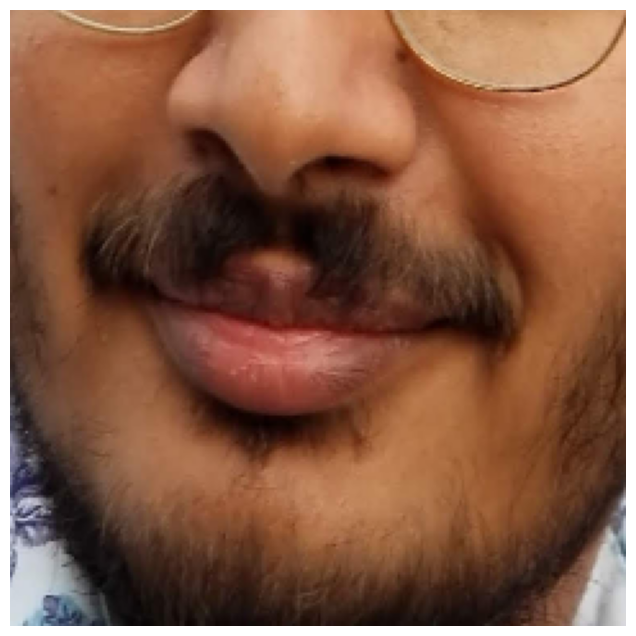

Image size: 64 X 64
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 3


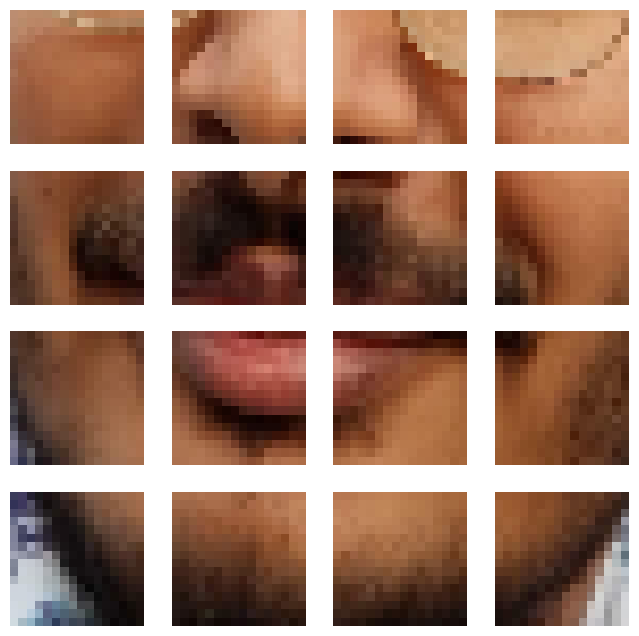

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming 'x_train' is already defined

# Choose a random image from x_train
image = x_train[np.random.choice(range(x_train.shape[0]))]

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()

# Resize the image
image_size = 64
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

# Extract patches
patch_size = 16
patches = tf.image.extract_patches(images=resized_image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')

# Reshape patches
patches = tf.reshape(patches, [-1, patch_size, patch_size, 3])

# Display patches
n = int(np.sqrt(patches.shape[0]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches):
    ax = plt.subplot(n, n, i + 1)
    plt.imshow(patch.numpy().astype("uint8"))
    plt.axis("off")

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[0]}")
print(f"Elements per patch: {patches.shape[-1]}")
plt.show()


## Creating the patch encoder
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [29]:
import tensorflow as tf

def patch_encoder_enhanced(patches, num_patches, projection_dim):
    """Encodes patches using functional API, learned positional embeddings, and layer normalization."""

    projected = tf.keras.layers.Dense(projection_dim)(patches)

    # Learned positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embeddings = tf.keras.layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)

    encoded = projected + positional_embeddings

    # Layer normalization for stability
    encoded = tf.keras.layers.LayerNormalization()(encoded)

    return encoded


## Building the ViT



In [30]:
pip install vit_keras

  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# parameters for model
batch_size = 256
image_size = 224

patch_size = 16

projection_dim = 64
transformer_units = [projection_dim * 2, projection_dim, ]
transformer_layers = 8
mlp_head_units = [2048, 1024]


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded